In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
url = "https://raw.githubusercontent.com/katarina74/ml_lessons/refs/heads/main/lesson_2/data/techparams_train.csv"
df = pd.read_csv(url)
df.head()

,index,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
0,0,9,-1.0,36457,9.0,4.3,0,3,4,2006,...,1,2,13,40.0,2018.0,16,3,0,1,2360
1,2,3,-1.0,44872,8.0,-1.0,3,7,4,1982,...,4,2,13,108.0,1993.0,34,3,0,1,3060
2,4,3,-1.0,55927,16.0,4.2,0,4,5,2014,...,4,2,13,55.0,2019.0,35,3,0,1,2648
3,5,0,-1.0,41405,10.3,-1.0,0,4,4,2000,...,4,2,13,55.0,2003.0,10,3,0,1,2513
4,7,8,-1.0,22523,19.0,-1.0,0,4,8,2000,...,4,1,13,62.0,2005.0,10,3,0,1,2703


Данные: технические характеристики разных конфигураций автомобилей

Таргет: длина колесной базы конфигурации (в миллиметрах).

Задача: добиться наименьшего MSE на test.

In [4]:
df.shape

(43245, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43245 entries, 0 to 43244
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           43245 non-null  int64  
 1   back-suspension                 43245 non-null  int64  
 2   battery-capacity                43245 non-null  float64
 3   charge-time                     43245 non-null  int64  
 4   compression                     43245 non-null  float64
 5   consumption-mixed               43245 non-null  float64
 6   cylinders-order                 43245 non-null  int64  
 7   cylinders-value                 43245 non-null  int64  
 8   engine-feeding                  43245 non-null  int64  
 9   engine-start                    43245 non-null  int64  
 10  engine-stop                     43245 non-null  int64  
 11  engine-type                     43245 non-null  int64  
 12  gear-type                       

## Предобработка данных

In [6]:
# Ищем дубликаты
df.duplicated().sum()

0

In [7]:
# Проверим, есть ли пропуски
df.isna().sum()

index                             0
back-suspension                   0
battery-capacity                  0
charge-time                       0
compression                       0
consumption-mixed                 0
cylinders-order                   0
cylinders-value                   0
engine-feeding                    0
engine-start                      0
engine-stop                       0
engine-type                       0
gear-type                         0
luxury                            0
max-speed                         0
power-electro-kw                  0
supply-system                     0
valves                            0
valvetrain                        0
weight                            0
configurations_auto-premiere      0
configurations_back-wheel-base    0
configurations_front-brake        0
configurations_safety-rating      0
configurations_seats              0
configurations_tank-volume        0
supergen_year-stop                0
models_country-from         

In [8]:
# Удаление ненужного индекса (он не информативен)
df.drop(columns=['index'], inplace=True)
df.sample(1)

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
34614,3,-1.0,17937,9.8,-1.0,0,4,4,1994,2000,...,4,2,8,58.0,2000.0,16,3,0,1,2200


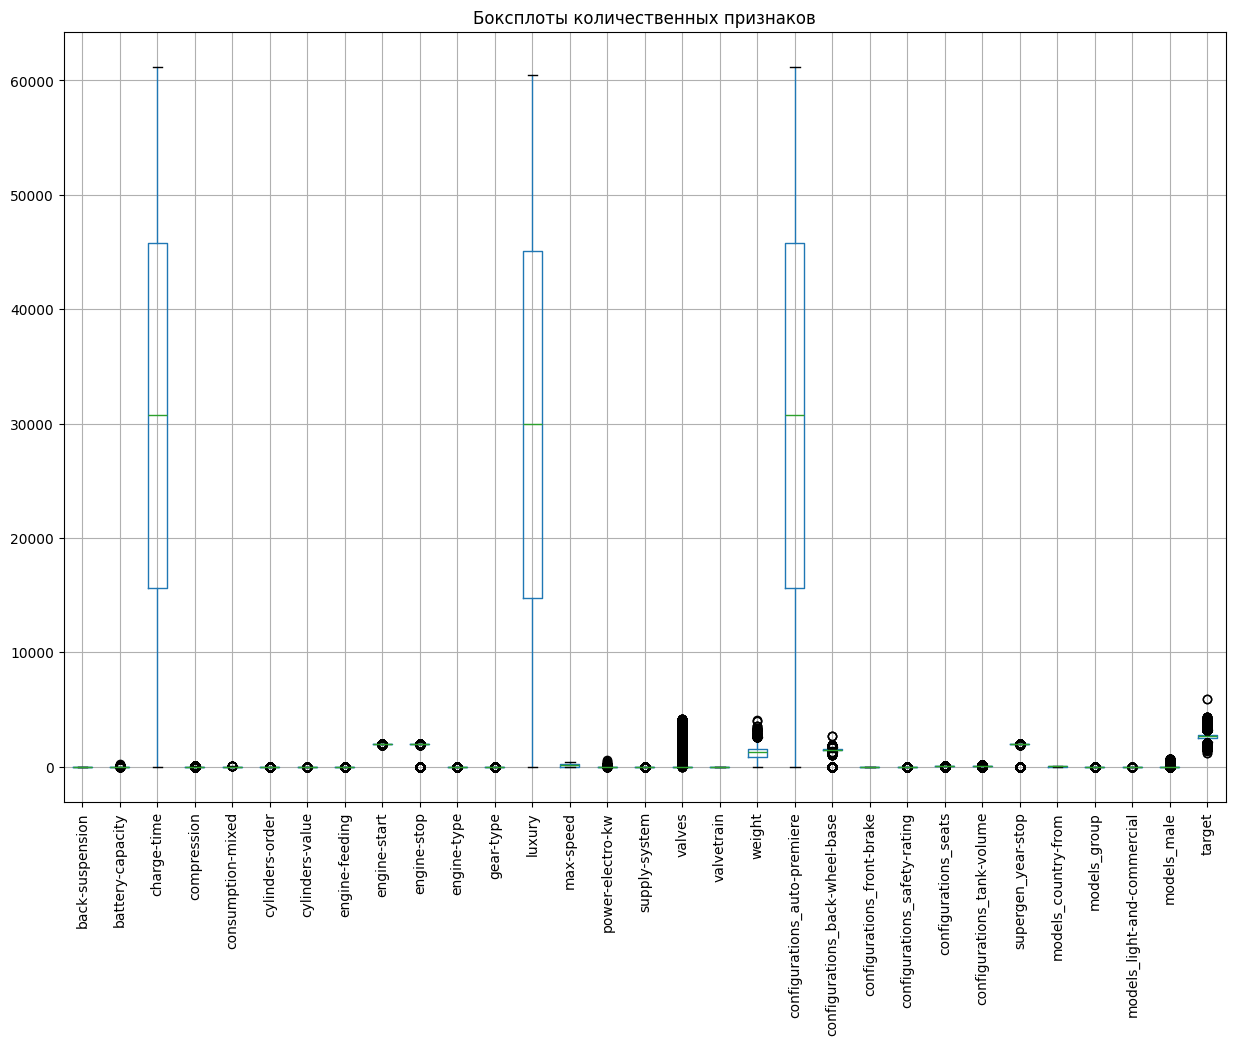

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем только числовые признаки
num_features = df.select_dtypes(include=['float64', 'int64']).columns

# Строим боксплоты
plt.figure(figsize=(15, 10))
df[num_features].boxplot(rot=90)
plt.title("Боксплоты количественных признаков")
plt.show()


In [10]:
columns_with_neg_ones = (df == -1.0).sum()
columns_with_neg_ones

back-suspension                       0
battery-capacity                  43093
charge-time                           0
compression                        9320
consumption-mixed                 17271
cylinders-order                       0
cylinders-value                       0
engine-feeding                        0
engine-start                          0
engine-stop                           0
engine-type                           0
gear-type                             0
luxury                                0
max-speed                         14885
power-electro-kw                  43032
supply-system                         0
valves                                0
valvetrain                            0
weight                             9399
configurations_auto-premiere          0
configurations_back-wheel-base     3067
configurations_front-brake            0
configurations_safety-rating          0
configurations_seats                  0
configurations_tank-volume         5408


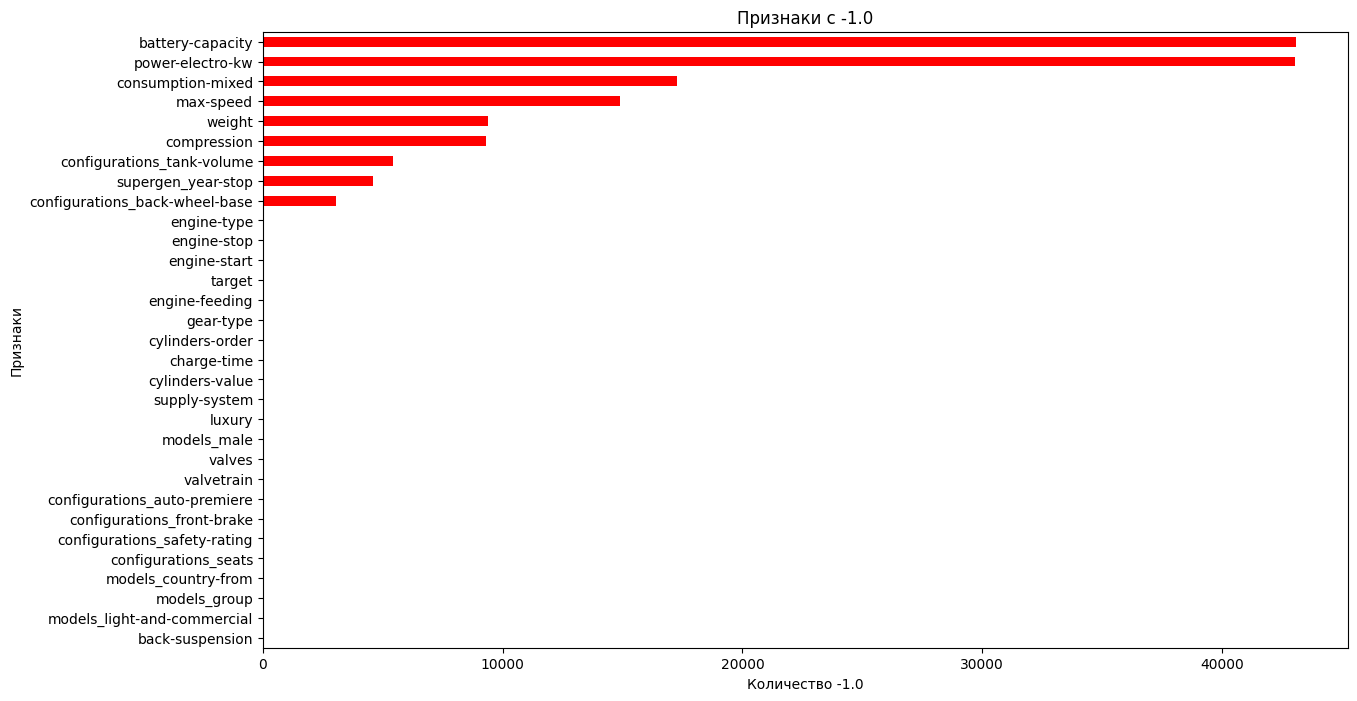

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
columns_with_neg_ones.sort_values().plot(kind="barh", color="red")
plt.xlabel("Количество -1.0")
plt.ylabel("Признаки")
plt.title("Признаки с -1.0")
plt.show()


In [12]:
total_rows = len(df)
percent_missing = (columns_with_neg_ones / total_rows) * 100
print("Процент -1.0 в каждом признаке:")
percent_missing.sort_values(ascending=False)

Процент -1.0 в каждом признаке:


battery-capacity                  99.648514
power-electro-kw                  99.507458
consumption-mixed                 39.937565
max-speed                         34.420164
weight                            21.734305
compression                       21.551624
configurations_tank-volume        12.505492
supergen_year-stop                10.581570
configurations_back-wheel-base     7.092149
configurations_safety-rating       0.000000
configurations_front-brake         0.000000
back-suspension                    0.000000
configurations_seats               0.000000
models_country-from                0.000000
models_group                       0.000000
models_light-and-commercial        0.000000
models_male                        0.000000
configurations_auto-premiere       0.000000
supply-system                      0.000000
valvetrain                         0.000000
valves                             0.000000
luxury                             0.000000
gear-type                       

Использование -1.0 как значения для пропущенных данных может исказить анализ и работу модели. 
Основные причины:

- Неправильная интерпретация: -1.0 может восприниматься как реальное значение, а не как пропуск.
- Влияние на средние и корреляции: -1.0 исказит статистику данных (например, среднее и дисперсию).
- Проблемы с моделированием: Большинство моделей ML воспринимают -1.0 как числовое значение, а не как NaN.

Поступим так:-1.0 заменим на NaN и обработаем:

Числовые признаки (например, compression, max-speed, weight) → можно заменить на медиану или предсказанные значения

### Удаление признаков с большим числом пропусков

In [13]:
columns_to_drop = ["battery-capacity", "power-electro-kw"]
df.drop(columns=columns_to_drop, inplace=True)
df.sample(1)

,back-suspension,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,engine-type,...,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male,target
3993,8,31518,9.4,10.7,0,4,4,2000,2010,2,...,4,1,13,57.0,2010.0,35,3,0,1,2616


### Заполнение пропусков средним / медианой / модой

- max-speed, weight, compression, consumption-mixed → медиана
- configurations_tank-volume, supergen_year-stop, configurations_back-wheel-base → медиана

In [14]:
columns_to_fill = [
    "max-speed", "weight", "compression", "consumption-mixed", 
    "configurations_tank-volume", "supergen_year-stop", "configurations_back-wheel-base"
]

df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.median()))


In [15]:
cat_features = ["configurations_safety-rating", "configurations_front-brake"]

In [16]:
# Заполнение категориальных признаков модой
df[cat_features] = df[cat_features].apply(lambda x: x.fillna(x.mode()[0]))

In [17]:
df[cat_features].isna().sum()

configurations_safety-rating    0
configurations_front-brake      0
dtype: int64

In [18]:
# Проверка
columns_with_neg_ones = (df == -1.0).sum()
columns_with_neg_ones

back-suspension                       0
charge-time                           0
compression                        9320
consumption-mixed                 17271
cylinders-order                       0
cylinders-value                       0
engine-feeding                        0
engine-start                          0
engine-stop                           0
engine-type                           0
gear-type                             0
luxury                                0
max-speed                         14885
supply-system                         0
valves                                0
valvetrain                            0
weight                             9399
configurations_auto-premiere          0
configurations_back-wheel-base     3067
configurations_front-brake            0
configurations_safety-rating          0
configurations_seats                  0
configurations_tank-volume         5408
supergen_year-stop                 4576
models_country-from                   0


In [19]:
num_features = [
    "compression", "consumption-mixed", "max-speed", "weight", 
    "configurations_tank-volume", "supergen_year-stop"
]
df[num_features] = df[num_features].apply(lambda x: x.replace(-1.0, np.nan).fillna(x.median()))

In [20]:
(df == -1.0).sum()

back-suspension                      0
charge-time                          0
compression                          0
consumption-mixed                    0
cylinders-order                      0
cylinders-value                      0
engine-feeding                       0
engine-start                         0
engine-stop                          0
engine-type                          0
gear-type                            0
luxury                               0
max-speed                            0
supply-system                        0
valves                               0
valvetrain                           0
weight                               0
configurations_auto-premiere         0
configurations_back-wheel-base    3067
configurations_front-brake           0
configurations_safety-rating         0
configurations_seats                 0
configurations_tank-volume           0
supergen_year-stop                   0
models_country-from                  0
models_group             

In [21]:
median_value = df[df["configurations_back-wheel-base"] != -1]["configurations_back-wheel-base"].median()
df["configurations_back-wheel-base"] = df["configurations_back-wheel-base"].replace(-1, median_value)


In [22]:
(df == -1.0).sum()

back-suspension                   0
charge-time                       0
compression                       0
consumption-mixed                 0
cylinders-order                   0
cylinders-value                   0
engine-feeding                    0
engine-start                      0
engine-stop                       0
engine-type                       0
gear-type                         0
luxury                            0
max-speed                         0
supply-system                     0
valves                            0
valvetrain                        0
weight                            0
configurations_auto-premiere      0
configurations_back-wheel-base    0
configurations_front-brake        0
configurations_safety-rating      0
configurations_seats              0
configurations_tank-volume        0
supergen_year-stop                0
models_country-from               0
models_group                      0
models_light-and-commercial       0
models_male                 

### Анализ корреляции 

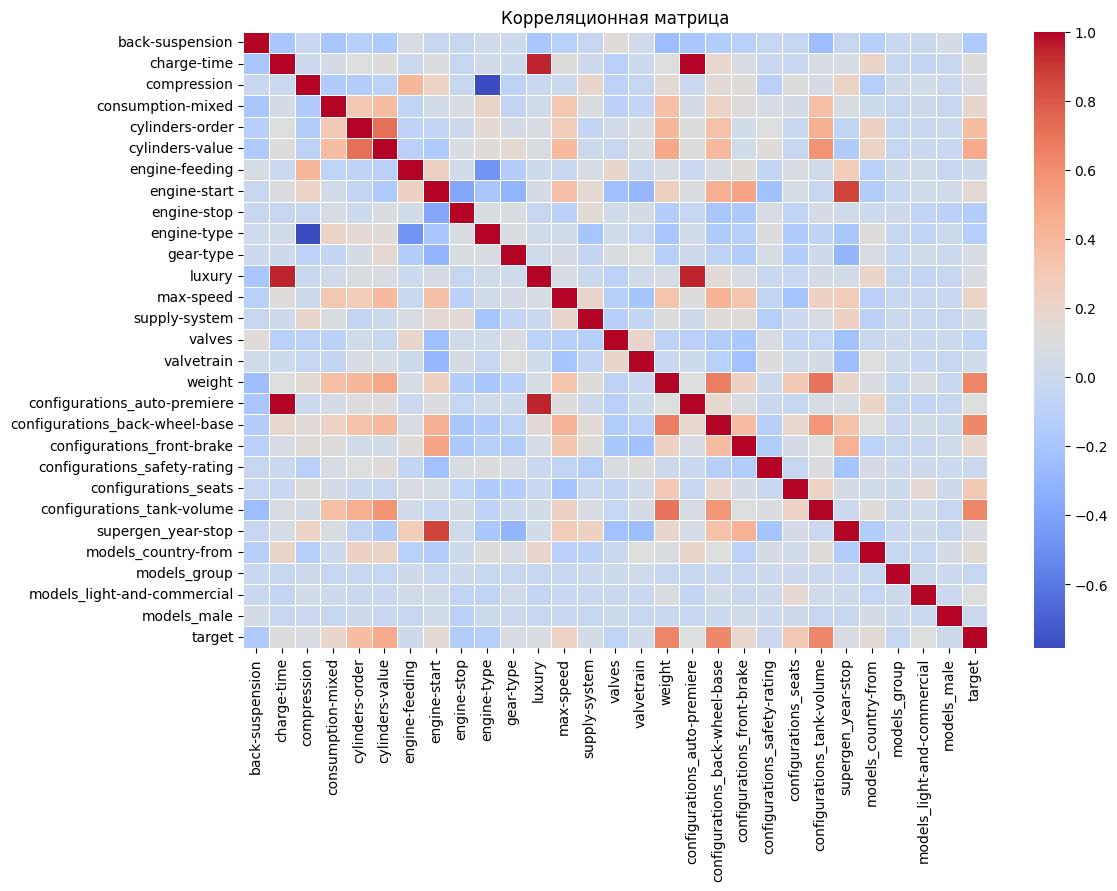

In [23]:
# Строим корреляционную матрицу
corr_matrix = df.corr()

# Визуализируем корреляцию
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()


### Регрессия (худшая)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на train/test
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f'R² (коэффициент детерминации): {r2:.4f}')

Mean Squared Error: 23607.960960476044
R² (коэффициент детерминации): 0.5882


### Кодирование категориальных переменных (и строим регрессию)

In [27]:
cat_features = df.select_dtypes(include=['int64']).columns.tolist()
print(f"Категориальные признаки:{cat_features}")

Категориальные признаки:['back-suspension', 'charge-time', 'cylinders-order', 'cylinders-value', 'engine-feeding', 'engine-start', 'engine-stop', 'engine-type', 'gear-type', 'luxury', 'supply-system', 'valves', 'valvetrain', 'configurations_auto-premiere', 'configurations_front-brake', 'configurations_safety-rating', 'configurations_seats', 'models_country-from', 'models_group', 'models_light-and-commercial', 'models_male', 'target']


In [28]:
# Применим Label Encoding для всех категориальных признаков:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на train/test
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
# Оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f'R² (коэффициент детерминации): {r2:.4f}')

Mean Squared Error: 8373.264224564928
R² (коэффициент детерминации): 0.6309


### Лассо-регрессия (Lasso Regression)

In [33]:
from sklearn.linear_model import Lasso

# Лассо-регрессия с оптимизированным параметром alpha
lasso = Lasso(alpha=0.01)  # Можно подобрать alpha через GridSearchCV
lasso.fit(X_train, y_train)

# Предсказания
y_pred_lasso = lasso.predict(X_test)

# Оценка модели
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression MSE: {mse_lasso:.4f}")
print(f"Lasso Regression R²: {r2_lasso:.4f}")


Lasso Regression MSE: 8372.3938
Lasso Regression R²: 0.6309


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.731e+06, tolerance: 7.696e+04
  model = cd_fast.enet_coordinate_descent(


### Применяем Ridge-регрессию:

In [34]:
from sklearn.linear_model import Ridge

# Гребневая регрессия
ridge = Ridge(alpha=1)  # Можно подобрать alpha через GridSearchCV
ridge.fit(X_train, y_train)

# Предсказания
y_pred_ridge = ridge.predict(X_test)

# Оценка модели
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression MSE: {mse_ridge:.4f}")
print(f"Ridge Regression R²: {r2_ridge:.4f}")

Ridge Regression MSE: 8373.0217
Ridge Regression R²: 0.6309


In [ ]:
### Градиентный бустинг

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

# Градиентный бустинг
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)

# Предсказания
y_pred_gbr = gbr.predict(X_test)

# Оценка модели
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting MSE: {mse_gbr:.4f}")
print(f"Gradient Boosting R²: {r2_gbr:.4f}")


Gradient Boosting MSE: 2614.0116
Gradient Boosting R²: 0.8848


In [ ]:
### Рандомный лес

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Гиперпараметры для подбора
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Модель
rf = RandomForestRegressor(random_state=42)

# RandomizedSearch
rf_search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Лучшие параметры
best_rf = rf_search.best_estimator_

# Предсказания
y_pred_rf = best_rf.predict(X_test)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RandomForest MSE: {mse_rf:.4f}")
print(f"RandomForest R²: {r2_rf:.4f}")

RandomForest MSE: 690.6514
RandomForest R²: 0.9696
